<font size="+3"><strong>Predicting Price with Location</strong></font>

In [4]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import wqet_grader
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 2 Assessment")

In this lesson, we're going to build on the work we did in the previous lesson. We're going to create a more complex `wrangle` function, use it to clean more data, and build a model that considers more features when predicting apartment price. 

In [5]:
VimeoVideo("656752925", h="701f3f4081", width=600)

# Prepare Data

## Import

In [6]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    df[['lat','lon']]=df['lat-lon'].str.split(',',expand=True).astype(float)
    

    return df

In [7]:
VimeoVideo("656752771", h="3a42896eb6", width=600)

**Task 2.2.1:** Use your `wrangle` function to create a DataFrame `frame1` from the CSV file `data/buenos-aires-real-estate-1.csv`.

In [8]:
frame1 = wrangle('data/buenos-aires-real-estate-1.csv')
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   place_with_parent_names     1343 non-null   object 
 3   lat-lon                     1300 non-null   object 
 4   price                       1343 non-null   float64
 5   currency                    1343 non-null   object 
 6   price_aprox_local_currency  1343 non-null   float64
 7   price_aprox_usd             1343 non-null   float64
 8   surface_total_in_m2         965 non-null    float64
 9   surface_covered_in_m2       1343 non-null   float64
 10  price_usd_per_m2            927 non-null    float64
 11  price_per_m2                1343 non-null   float64
 12  floor                       379 non-null    float64
 13  rooms                       1078 

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...


For our model, we're going to consider apartment location, specifically, latitude and longitude. Looking at the output from `frame1.info()`, we can see that the location information is in a single column where the data type is `object` (pandas term for `str` in this case). In order to build our model, we need latitude and longitude to each be in their own column where the data type is `float`. 

In [9]:
VimeoVideo("656751955", h="e47002428d", width=600)

In [18]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    df[['lat','lon']]=df['lat-lon'].str.split(',',expand=True).astype(float)
    df.drop(columns='lat-lon',inplace=True)

    return df

In [19]:
frame1 = wrangle('data/buenos-aires-real-estate-1.csv')
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   place_with_parent_names     1343 non-null   object 
 3   price                       1343 non-null   float64
 4   currency                    1343 non-null   object 
 5   price_aprox_local_currency  1343 non-null   float64
 6   price_aprox_usd             1343 non-null   float64
 7   surface_total_in_m2         965 non-null    float64
 8   surface_covered_in_m2       1343 non-null   float64
 9   price_usd_per_m2            927 non-null    float64
 10  price_per_m2                1343 non-null   float64
 11  floor                       379 non-null    float64
 12  rooms                       1078 non-null   float64
 13  expenses                    349 n

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
29,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
40,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
41,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


**Task 2.2.2:** Add to the `wrangle` function below so that, in the DataFrame it returns, the `"lat-lon"` column is replaced by separate `"lat"` and `"lon"` columns. Don't forget to also drop the `"lat-lon"` column. Be sure to rerun all the cells above before you continue.

- [What's a function?](../%40textbook/02-python-advanced.ipynb#Functions)
- [Split the strings in one column to create another using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Splitting-Strings)
- [Drop a column from a DataFrame using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)

In [16]:
frame1['lat-lon'].str.split(',',expand=True).astype(float)

,0,1
4,-34.584651,-58.454693
9,-34.638979,-58.500115
29,-34.615847,-58.459957
40,-34.625222,-58.382382
41,-34.610610,-58.412511
...,...,...
8589,-34.631591,-58.370191
8590,-34.604555,-58.418206
8593,-34.624002,-58.390588
8601,-34.601455,-58.378132


In [20]:
# Check your work
assert (
    frame1.shape[0] == 1343
), f"`frame1` should have 1343 rows, not {frame1.shape[0]}."
assert frame1.shape[1] == 17, f"`frame1` should have 17 columns, not {frame1.shape[1]}."

Now that our `wrangle` function is working, let's use it to clean more data!

In [21]:
VimeoVideo("656751853", h="da40b0a474", width=600)

**Task 2.2.3:** Use you revised `wrangle` function create a DataFrames `frame2` from the file `data/buenos-aires-real-estate-2.csv`.

In [22]:
frame2 = wrangle('data/buenos-aires-real-estate-2.csv')

In [23]:
# Check your work
assert (
    frame2.shape[0] == 1315
), f"`frame1` should have 1315 rows, not {frame2.shape[0]}."
assert frame2.shape[1] == 17, f"`frame1` should have 17 columns, not {frame2.shape[1]}."

As you can see, using a function is much quicker than cleaning each file individually like we did in the last project. Let's combine our DataFrames so we can use then to train our model.

In [24]:
VimeoVideo("656751405", h="d1f95ab108", width=600)

**Task 2.2.4:** Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate `frame1` and `frame2` into a new DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.

- [Concatenate two or more DataFrames using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Concatenating)

In [28]:
frame2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 2 to 8585
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1315 non-null   object 
 1   property_type               1315 non-null   object 
 2   place_with_parent_names     1315 non-null   object 
 3   price                       1315 non-null   float64
 4   currency                    1315 non-null   object 
 5   price_aprox_local_currency  1315 non-null   float64
 6   price_aprox_usd             1315 non-null   float64
 7   surface_total_in_m2         933 non-null    float64
 8   surface_covered_in_m2       1315 non-null   float64
 9   price_usd_per_m2            891 non-null    float64
 10  price_per_m2                1315 non-null   float64
 11  floor                       390 non-null    float64
 12  rooms                       1059 non-null   float64
 13  expenses                    339 n

In [29]:
df = pd.concat([frame1,frame2], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2658 non-null   object 
 1   property_type               2658 non-null   object 
 2   place_with_parent_names     2658 non-null   object 
 3   price                       2658 non-null   float64
 4   currency                    2658 non-null   object 
 5   price_aprox_local_currency  2658 non-null   float64
 6   price_aprox_usd             2658 non-null   float64
 7   surface_total_in_m2         1898 non-null   float64
 8   surface_covered_in_m2       2658 non-null   float64
 9   price_usd_per_m2            1818 non-null   float64
 10  price_per_m2                2658 non-null   float64
 11  floor                       769 non-null    float64
 12  rooms                       2137 non-null   float64
 13  expenses                    688 n

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


In [30]:
# Check your work
assert df.shape == (2658, 17), f"`df` is the wrong size: {df.shape}"

## Explore

In the last lesson, we built a simple linear model that predicted apartment price based on one feature, `"surface_covered_in_m2"`. In this lesson, we're building a multiple linear regression model that predicts price based on two features, `"lon"` and `"lat"`. This means that our data visualizations now have to communicate three pieces of information: Longitude, latitude, and price. How can we represent these three attributes on a two-dimensional screen?

One option is to incorporate color into our scatter plot. For example, in the Mapbox scatter plot below, the location of each point represents latitude and longitude, and color represents price. 

In [31]:
VimeoVideo("656751031", h="367be02e14", width=600)

**Task 2.2.5:** Complete the code below to create a [Mapbox scatter plot](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html) that shows the location of the apartments in `df`. 

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a Mapbox scatter plot in plotly express.](../%40textbook/08-visualization-plotly.ipynb#Mapbox-Scatter-Plots) 

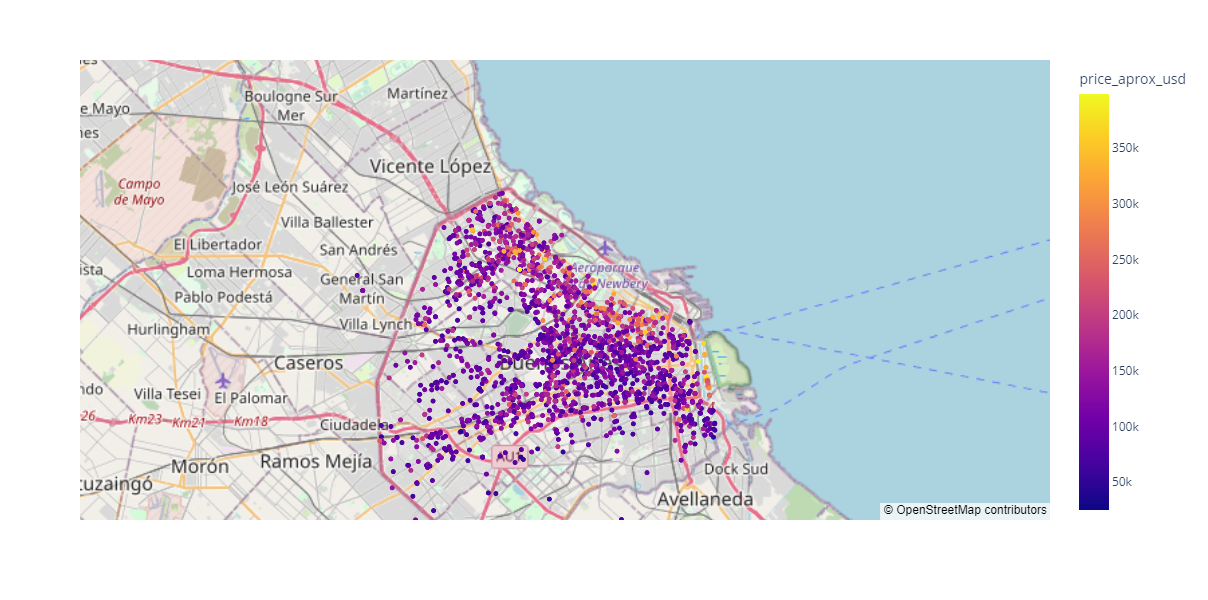

In [38]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

Another option is to add a third dimension to our scatter plot. We can plot longitude on the x-axis and latitude on the y-axis (like we do in the map above), and then add a z-axis with price. 

In [39]:
VimeoVideo("656750669", h="574287f687", width=600)

**Task 2.2.6:** Complete the code below to create a 3D scatter plot, with `"lon"` on the x-axis, `"lat"` on the y-axis, and `"price_aprox_usd"` on the z-axis.

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a 3D scatter plot in plotly express.](../%40textbook/08-visualization-plotly.ipynb#3D-Scatter-Plots)

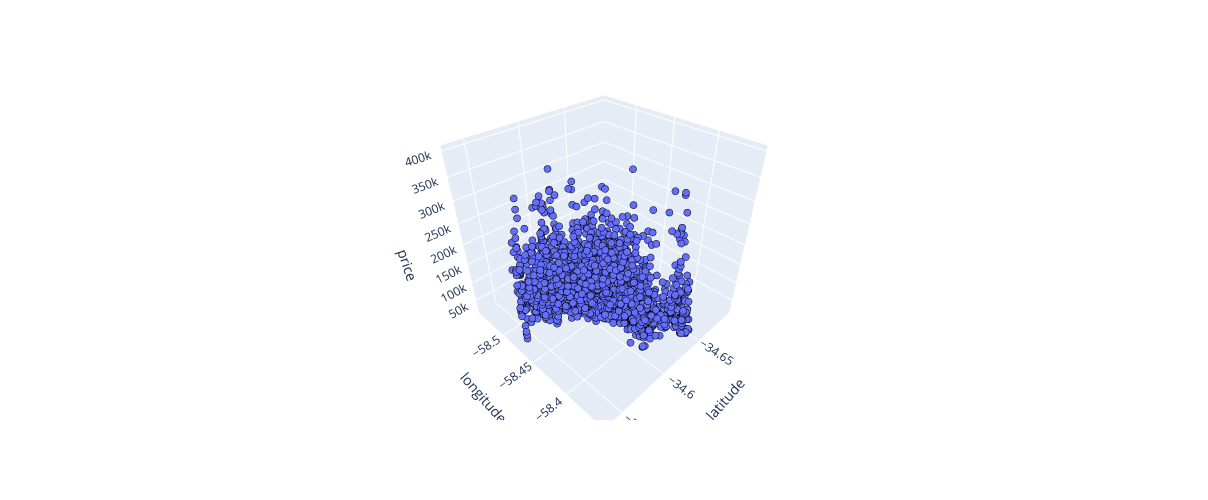

In [40]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x='lat',
    y='lon',
    z='price_aprox_usd',
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

<div class="alert alert-block alert-info">
<b>Tip:</b> 3D visualizations are often harder for someone to interpret than 2D visualizations. We're using one here because it will help us visualize our model once it's built, but as a rule, it's better to stick with 2D when your communicating with an audience.
</div>

In the last lesson, we represented our simple model as a line imposed on a 2D scatter plot.

<center><img src="../images/proj-2.002.png" alt="Scatter plot of price versus area with line plot"/></center>

How do you think we'll represent our multiple linear regression model in the 3D plot we just made?

## Split

Even though we're building a different model, the steps we follow will be the same. Let's separate our features (latitude and longitude) from our target (price). 

In [41]:
VimeoVideo("656750457", h="09f5fe3962", width=600)

**Task 2.2.7:** Create the feature matrix named `X_train`. It should contain two features: `["lon", "lat"]`. 

- [What's a feature matrix?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [Subset a DataFrame by selecting one or more columns in pandas.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 

In [42]:
features = ["lon", "lat"]
X_train = df[features]
X_train.shape

(2658, 2)

In [43]:
VimeoVideo("656750323", h="1a82090b9b", width=600)

**Task 2.2.8:** Create the target vector named `y_train`, which you'll use to train your model. Your target should be `"price_aprox_usd"`. Remember that, in most cases, your target vector should be one-dimensional. 

- [What's a target vector?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [Select a Series from a DataFrame in pandas.](../%40textbook/04-pandas-advanced.ipynb#Select-a-Series-from-a-DataFrame) 

In [44]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(2658,)

# Build Model

## Baseline

Again, we need to set a baseline so we can evaluate our model's performance. You'll notice that the value of `y_mean` is not exactly the same as it was in the previous lesson. That's because we've added more observations to our training data.

In [45]:
VimeoVideo("656750112", h="1ef669fe2b", width=600)

**Task 2.2.9:** Calculate the mean of your target vector `y_train` and assign it to the variable `y_mean`.

- [Calculate summary statistics for a DataFrame or Series in pandas.](../%40textbook/05-pandas-summary-statistics.ipynb#Working-with-Summary-Statistics)

In [46]:
y_mean = y_train.mean()

**Task 2.2.10:** Create a list named `y_pred_baseline` that contains the value of `y_mean` repeated so that it's the same length at `y_train`.

- [Calculate the length of a list in Python.](../%40textbook/02-python-advanced.ipynb#Functions)

In [47]:
y_pred_baseline = [y_mean]*len(y_train)
y_pred_baseline[:5]

[134732.9734048155,
 134732.9734048155,
 134732.9734048155,
 134732.9734048155,
 134732.9734048155]

In [48]:
VimeoVideo("656749994", h="50c71bf4e5", width=600)

**Task 2.2.11:** Calculate the baseline mean absolute error for your predictions in `y_pred_baseline` as compared to the true targets in `y_train`.

- [What's a performance metric?](../%40textbook/12-ml-core.ipynb#Performance-Metrics)
- [What's mean absolute error?](../%40textbook/12-ml-core.ipynb#Performance-Metrics)
- [Calculate the mean absolute error for a list of predictions in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [50]:
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 134732.97
Baseline MAE: 45422.75


## Iterate

Take a moment to scroll up to the output for `df.info()` and look at the values in the `"Non-Null Count"` column. Because of the math it uses, a linear regression model can't handle observations where there are missing values. Do you see any columns where this will be a problem?

In the last project, we simply dropped rows that contained `NaN` values, but this isn't ideal. Models generally perform better when they have more data to train with, so every row is precious. Instead, we can fill in these missing values using information we get from the whole column — a process called **imputation**. There are many different strategies for imputing missing values, and one of the most common is filling in the missing values with the mean of the column.

In addition to **predictors** like `LinearRegression`, scikit-learn also has **transformers** that help us deal with issues like missing values. Let's see how one works, and then we'll add it to our model.

In [51]:
VimeoVideo("656748776", h="014f943c46", width=600)

**Task 2.2.12:** Instantiate a [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) named `imputer`.

- [What's imputation?](../%40textbook/12-ml-core.ipynb#Imputation) 
- [Instantiate a transformer in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)

In [5]:
model = LinearRegression()
model.fit(X_train,y_train)

NameError: name 'LinearRegression' is not defined

In [6]:
imputer = SimpleImputer()

NameError: name 'SimpleImputer' is not defined

In [3]:
# Check your work
assert isinstance(imputer, SimpleImputer)

NameError: name 'imputer' is not defined

Just like a predictor, a transformer has a `fit` method. In the case of our `SimpleImputer`, this is the step where it calculates the mean values for each numerical column. 

In [59]:
VimeoVideo("656748659", h="fdaa8d0329", width=600)

**Task 2.2.13:** Fit your transformer `imputer` to the feature matrix `X`.

- [Fit a transformer to training data in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)

In [2]:
imputer.fit(X_train)

NameError: name 'imputer' is not defined

In [7]:
# Check your work
check_is_fitted(imputer)

NameError: name 'check_is_fitted' is not defined

Here's where transformers diverge from predictors. Instead of using a method like `predict`, we use the `transform` method. This is the step where the transformer fills in the missing values with the means it's calculated. 

In [65]:
VimeoVideo("656748527", h="d76e63760c", width=600)

**Task 2.2.14:** Use your `imputer` to transform the feature matrix `X_train`. Assign the transformed data to the variable `XT_train`.

- [Transform data using a transformer in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)

In [8]:
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

NameError: name 'imputer' is not defined

In [9]:
# Check your work
assert XT_train.shape == (2658, 2), f"`XT_train` is the wrong shape: {XT_train.shape}"
assert (
    np.isnan(XT_train).sum() == 0
), "Your feature matrix still has `NaN` values. Did you forget to transform is using `imputer`?"

NameError: name 'XT_train' is not defined

Okay! Our data is free of missing values, and we have a good sense for how predictors work in scikit-learn. However, the truth is you'll rarely do data transformations this way. Why? A model may require multiple transformers, and doing all those transformations one-by-one is slow and likely to lead to errors. 🤦‍♀️ Instead, we can combine our transformer and predictor into a single object called a `pipeline`. 

In [68]:
VimeoVideo("656748360", h="50b4643a26", width=600)

**Task 2.2.15:** Create a pipeline named `model` that contains a `SimpleImputer` transformer followed by a `LinearRegression` predictor.

- [What's a pipeline?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)
- [Create a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)

In [69]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

In [70]:
assert isinstance(model, Pipeline), "Did you instantiate your model?"

With our pipeline assembled, we use the `fit` method, which will train the transformer, transform the data, then pass the transformed data to the predictor for training, all in one step. Much easier!

In [71]:
VimeoVideo("656748234", h="59ba7958d5", width=600)

**Task 2.2.16:** Fit your model to the data, `X_train` and `y_train`.

- [Fit a model to training data in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Fitting-a-Model-to-Training-Data)

In [72]:
model.fit(X_train,y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [74]:
# Check your work
check_is_fitted(model["linearregression"])

Success! Let's see how our trained model performs. 

## Evaluate

As always, we'll start by evaluating our model's performance on the training data. 

In [75]:
VimeoVideo("656748155", h="5672ef44cb", width=600)

**Task 2.2.17:** Using your model's [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) method, create a list of predictions for the observations in your feature matrix `X_train`. Name this list `y_pred_training`. 

- [Generate predictions using a trained model in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)

In [76]:
y_pred_training = model.predict(X_train)

In [77]:
# Check your work
assert y_pred_training.shape == (2658,)

In [78]:
VimeoVideo("656748205", h="13144556a6", width=600)

**Task 2.2.18:** Calculate the training mean absolute error for your predictions in `y_pred_training` as compared to the true targets in `y_train`.

- [Calculate the mean absolute error for a list of predictions in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [79]:
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 42962.72


It looks like our model performs a little better than the baseline. This suggests that latitude and longitude aren't as strong predictors of price as size is. 

Now let's check our test performance. Remember, once we test our model, there's no more iteration allowed. 

**Task 2.2.19:** Run the code below to import your test data `buenos-aires-test-features.csv` into a DataFrame and generate a Series of predictions using your model. Then run the following cell to submit your predictions to the grader.

- [What's generalizability?](../%40textbook/12-ml-core.ipynb#Generalization)
- [Generate predictions using a trained model in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)
- [Calculate the mean absolute error for a list of predictions in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [80]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    136372.324695
1    168620.352353
2    130231.628267
3    102497.549527
4    123482.077850
dtype: float64

In [81]:
wqet_grader.grade("Project 2 Assessment", "Task 2.2.19", y_pred_test)

Again, we want our test performance to be about the same as our training performance, but it's OK if it's not quite as good. 

# Communicate Results

Let's take a look at the equation our model has come up with for predicting price based on latitude and longitude. We'll need to expand on our formula to account for both features. 

<center><img src="../images/proj-2.005.png" alt="Equation: y = beta 0 + beta 1 * x" style="width: 400px;"/></center>

In [82]:
VimeoVideo("656747630", h="b90db6b373", width=600)

**Task 2.2.20:** Extract the intercept and coefficients for your model. 

- [What's an intercept in a linear model?](../%40textbook/12-ml-core.ipynb#Model-Types)
- [What's a coefficient in a linear model?](../%40textbook/12-ml-core.ipynb#Model-Types)
- [Access an object in a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [85]:
intercept = model.named_steps['linearregression'].intercept_
coefficients = model.named_steps['linearregression'].coef_
print(intercept,coefficients)

38113587.05164884 [196709.41663632 765466.57502018]


**Task 2.2.21:** Complete the code below and run the cell to print the equation that your model has determined for predicting apartment price based on latitude and longitude.

- [What's an f-string?](../%40textbook/02-python-advanced.ipynb#Working-with-f-strings-)

In [89]:
print(
    
    f"price = {model.named_steps['linearregression'].intercept_.round(2)} + ({model.named_steps['linearregression'].coef_[0].round(2)} * longitude) + ({model.named_steps['linearregression'].coef_[1].round(2)} * latitude)"
)

price = 38113587.05 + (196709.42 * longitude) + (765466.58 * latitude)


What does this equation tell us? As you move north and west, the predicted apartment price increases. 

At the start of the notebook, you thought about how we would represent our linear model in a 3D plot. If you guessed that we would use a plane, you're right!

In [90]:
VimeoVideo("656746928", h="71bfe94764", width=600)

**Task 2.2.22:** Complete the code below to create a 3D scatter plot, with `"lon"` on the x-axis, `"lat"` on the y-axis, and `"price_aprox_usd"` on the z-axis.

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a 3D scatter plot in plotly express.](../%40textbook/08-visualization-plotly.ipynb#3D-Scatter-Plots)

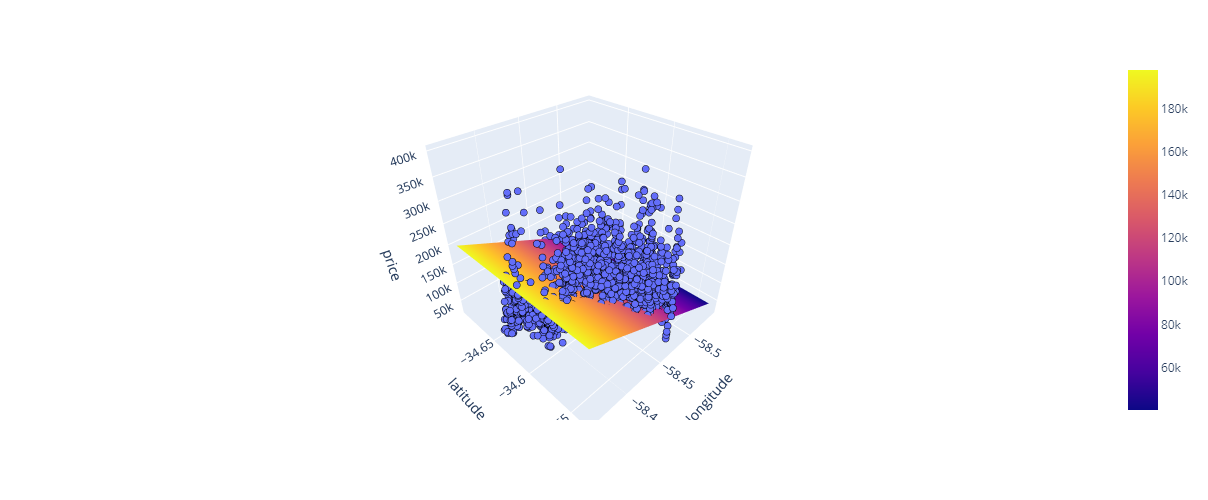

In [95]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x='lon',
    y='lat',
    z='price_aprox_usd',
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Create x and y coordinates for model representation
x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use model to predict z coordinates
z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

# Add plane to figure
fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
